# Import'ai #

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd

import unicodedata #kirčių panaikinimui varduose
import matplotlib.pyplot as plt
from collections import Counter
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

import requests #scap'inimui
from bs4 import BeautifulSoup #scrap'inimui

In [ ]:
if torch.cuda.is_available():
  print("GPU is available")
  device = torch.device("cuda")
else:
  print("GPU is not available, using CPU instead")
  device = torch.device("cpu")

GPU is not available, using CPU instead


#Vardų scrap'inimas iš vlkk.lt#

In [ ]:
vardai_M = []
vardai_F = []

for key in ['a', 'b', 'c', 'c-2', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l',
            'm', 'n', 'o', 'p', 'r', 's', 's-2', 't', 'u', 'v', 'z', 'z-2']:
    url_vyro = f'https://vardai.vlkk.lt/sarasas/{key}/?lytis=vyro&kilme='
    url_moters =f'https://vardai.vlkk.lt/sarasas/{key}/?lytis=moters&kilme='

    #Vyrų vardai
    response = requests.get(url_vyro)
    soup = BeautifulSoup(response.text, 'html.parser')
    vyro_links = soup.find_all('a', class_='names_list__links names_list__links--man')
    vardai_M += [name.text for name in vyro_links]

    #Moterų vardai
    response = requests.get(url_moters)
    soup = BeautifulSoup(response.text, 'html.parser')
    moters_links = soup.find_all('a', class_='names_list__links names_list__links--woman')
    vardai_F += [name.text for name in moters_links]

#Išsaugome
np.savetxt('vyru_vardai.txt', vardai_M, fmt='%s', header='name', comments='', newline='\n')
np.savetxt('moteru_vardai.txt', vardai_F, fmt='%s', header='name', comments='', newline='\n')

#Kirčių panaikinimas, kad modeliui būtų lengviau mokintis#

In [ ]:
# List of Lithuanian characters to keep
keep_chars = "ąčęėįšųūžĄČĘĖĮŠŲŪŽ"

# Function to remove accents but keep specific characters unchanged
def remove_accents(name, keep_chars):
    cleaned = []
    for char in name:
        if char in keep_chars:  # Keep Lithuanian characters as is
            cleaned.append(char)
        else:
            # Normalize and remove accents for other characters
            decomposed = unicodedata.normalize('NFD', char)
            base_char = ''.join(c for c in decomposed if not unicodedata.combining(c))
            cleaned.append(base_char)
    return ''.join(cleaned)

# Process the names
moteru_vardai_no_accents = [remove_accents(name, keep_chars) for name in vardai_F]
vyru_vardai_no_accents = [remove_accents(name, keep_chars) for name in vardai_M]



In [ ]:
np.savetxt('vyru_vardai_no_accents.txt', vyru_vardai_no_accents, fmt='%s', header='name', comments='', newline='\n')
np.savetxt('moteru_vardai_no_accents.txt', moteru_vardai_no_accents, fmt='%s', header='name', comments='', newline='\n')

# Raidžių pasiskirstymas (nėra kirčių)#

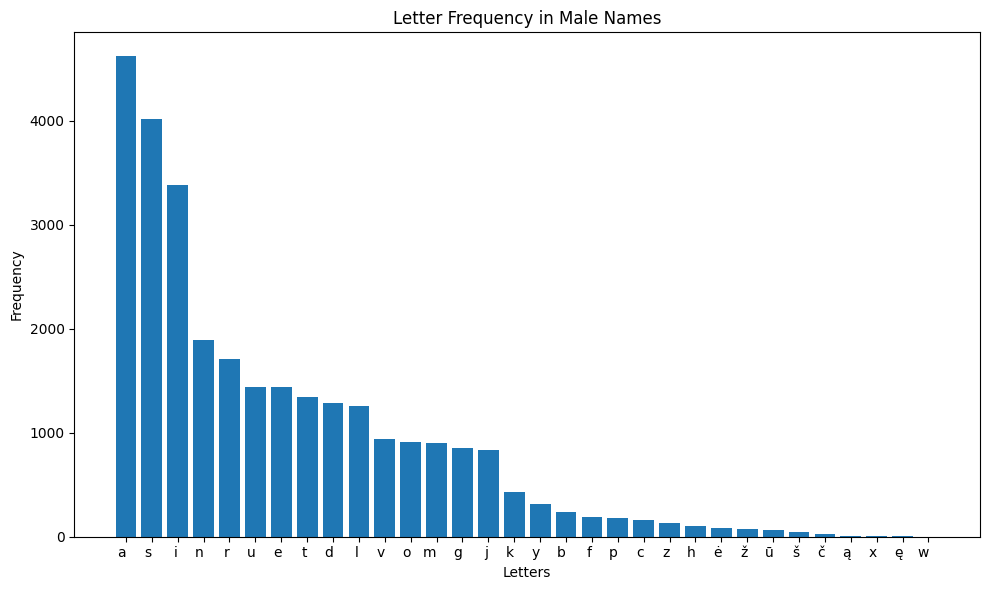

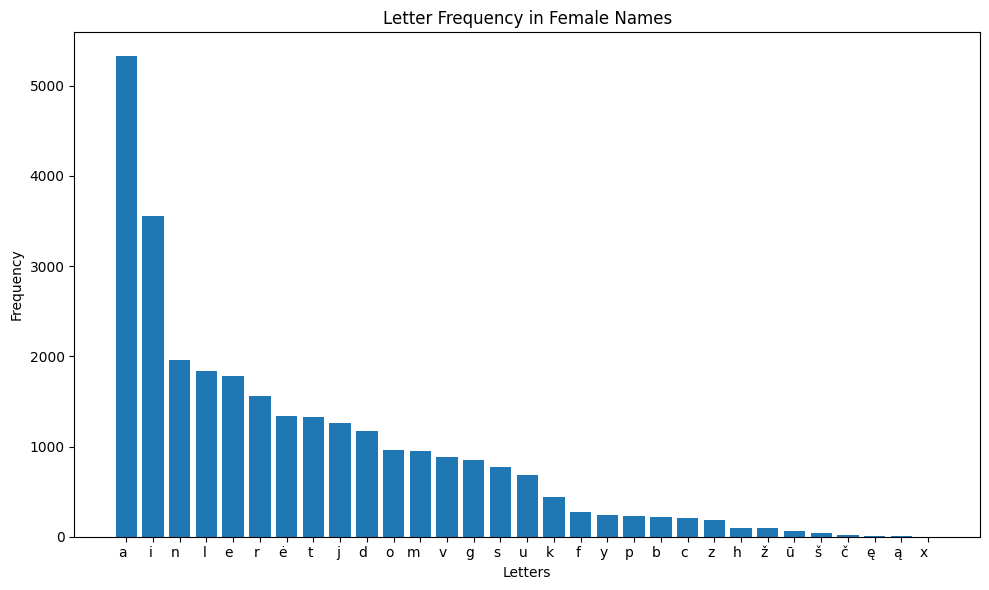

In [ ]:
def plot_letter_frequency(names, title):
    all_letters = ''.join(names).lower()  # Convert all letters to lowercase
    letter_counts = Counter(all_letters)
    letter_df = pd.DataFrame.from_dict(letter_counts, orient='index', columns=['Frequency'])
    letter_df = letter_df.sort_values(by='Frequency', ascending=False)

    plt.figure(figsize=(10, 6))
    plt.bar(letter_df.index, letter_df['Frequency'])
    plt.title(title)
    plt.xlabel("Letters")
    plt.ylabel("Frequency")
    plt.xticks(rotation=0, ha='right')
    plt.tight_layout()
    plt.show()

plot_letter_frequency(vyru_vardai_no_accents, "Letter Frequency in Male Names")
plot_letter_frequency(moteru_vardai_no_accents, "Letter Frequency in Female Names")

# Vardų kodavimas skaitmenimis #

In [ ]:
class NameDataset(Dataset):
    def __init__(self, csv_file):
        self.names = pd.read_csv(csv_file)['name'].values
        self.chars = sorted(list(set(''.join(self.names) + ' ')))  # Include padding character
        self.char_to_int = {c: i for i, c in enumerate(self.chars)}
        self.int_to_char = {i: c for c, i in self.char_to_int.items()}
        self.vocab_size = len(self.chars)

    def __len__(self):
        return len(self.names)

    def __getitem__(self, idx):
        name = self.names[idx] + ' '  # Add padding character at the end
        encoded_name = [self.char_to_int[char] for char in name]
        return torch.tensor(encoded_name)

In [ ]:
# Susikuriame užkoduotus vardų dataset'us
male_dataset = NameDataset('vyru_vardai_no_accents.txt')
female_dataset = NameDataset('moteru_vardai_no_accents.txt')

# Pad'ingas ir duomenų data load'eriai #

In [ ]:
def pad_collate(batch):
    padded_seqs = pad_sequence(batch, batch_first=True, padding_value=0)
    input_seq = padded_seqs[:, :-1]
    target_seq = padded_seqs[:, 1:]
    return input_seq, target_seq

# Susikuriame vyrų ir moterų vardų dataload'erius
male_data_loader = DataLoader(male_dataset, 32, shuffle=True, collate_fn=pad_collate)
female_data_loader = DataLoader(female_dataset, 32, shuffle=True, collate_fn=pad_collate)

# Transformeris #

In [ ]:
class MinimalTransformer(nn.Module):
    def __init__(self, vocab_size, embed_size, num_heads):
        super(MinimalTransformer, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.positional_encoding = nn.Parameter(torch.randn(1, 100, embed_size))
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=embed_size, nhead=num_heads)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=1)
        self.output_layer = nn.Linear(embed_size, vocab_size)

    def forward(self, x):
        x = self.embed(x) + self.positional_encoding[:, :x.size(1), :]
        x = self.transformer_encoder(x)
        x = self.output_layer(x)
        return x

# Training architektūra #

In [ ]:
def train_model(model, dataloader, epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())

    model.to(device)

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0

        for input_seq, target_seq in dataloader:
            input_seq = input_seq.to(device)
            target_seq = target_seq.to(device)

            optimizer.zero_grad()
            output = model(input_seq)
            loss = criterion(output.transpose(1, 2), target_seq)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        average_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1}, Average Loss: {average_loss}")


# Modelių treniravimas #

In [ ]:
#parametrai
EMBED_SIZE_M = 128
NUM_HEADS_M = 16
EPOCHS_M = 150

vyru_model = MinimalTransformer(vocab_size=male_dataset.vocab_size, embed_size=EMBED_SIZE_M, num_heads=NUM_HEADS_M)
print("\nTraining Male Names Model:")
train_model(vyru_model, male_data_loader, epochs=EPOCHS_M)

# Išsaugome
torch.save(vyru_model.state_dict(), 'vyru_model.pth')

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(



Training Male Names Model:
Epoch 1, Average Loss: 1.3694173580358837
Epoch 2, Average Loss: 1.1886560783898534
Epoch 3, Average Loss: 1.162587328883242
Epoch 4, Average Loss: 1.1466144653391246
Epoch 5, Average Loss: 1.143225231939111
Epoch 6, Average Loss: 1.1349669497860364
Epoch 7, Average Loss: 1.1296855797452374
Epoch 8, Average Loss: 1.1382829359740265
Epoch 9, Average Loss: 1.1238144823342315
Epoch 10, Average Loss: 1.11035887071909
Epoch 11, Average Loss: 1.1286570572656047
Epoch 12, Average Loss: 1.1177595814397512
Epoch 13, Average Loss: 1.123940312665356
Epoch 14, Average Loss: 1.1106376657801227
Epoch 15, Average Loss: 1.1139726914650152
Epoch 16, Average Loss: 1.1147078310162568
Epoch 17, Average Loss: 1.1068416587577379
Epoch 18, Average Loss: 1.1128251641249853
Epoch 19, Average Loss: 1.1045120122018925
Epoch 20, Average Loss: 1.105487579649145
Epoch 21, Average Loss: 1.1081949142385121
Epoch 22, Average Loss: 1.1023439065483975
Epoch 23, Average Loss: 1.103397581695525

In [ ]:
#parametrai
EMBED_SIZE_F = 128
NUM_HEADS_F = 16
EPOCHS_F = 150

moteru_model = MinimalTransformer(vocab_size=female_dataset.vocab_size, embed_size=EMBED_SIZE_F, num_heads=NUM_HEADS_F)
print("\nTraining Female Names Model:")
train_model(moteru_model, female_data_loader, epochs=EPOCHS_F)

# Išsaugome
torch.save(moteru_model.state_dict(), 'female_model.pth')


Training Female Names Model:


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1, Average Loss: 1.4204184300917433
Epoch 2, Average Loss: 1.2230828001086873
Epoch 3, Average Loss: 1.2074618760804485
Epoch 4, Average Loss: 1.1877861829628622
Epoch 5, Average Loss: 1.1781700271412843
Epoch 6, Average Loss: 1.1727342829668432
Epoch 7, Average Loss: 1.1785096821928382
Epoch 8, Average Loss: 1.1718181842251827
Epoch 9, Average Loss: 1.164028231362651
Epoch 10, Average Loss: 1.1713704950827406
Epoch 11, Average Loss: 1.172722900272312
Epoch 12, Average Loss: 1.1654394649921502
Epoch 13, Average Loss: 1.1627376913128042
Epoch 14, Average Loss: 1.165501514323672
Epoch 15, Average Loss: 1.1574629885809762
Epoch 16, Average Loss: 1.1536842226085806
Epoch 17, Average Loss: 1.1662178653523438
Epoch 18, Average Loss: 1.1573443990901
Epoch 19, Average Loss: 1.1535077381851082
Epoch 20, Average Loss: 1.1545547574086297
Epoch 21, Average Loss: 1.1561165864306284
Epoch 22, Average Loss: 1.1523115917256004
Epoch 23, Average Loss: 1.1535482921994717
Epoch 24, Average Loss: 1.

In [ ]:
torch.save(vyru_model.state_dict(), 'vyru_model.pth')  # Save the model to a file
print("Vyrų model saved to 'vyru_model.pth'.")

Vyrų model saved to 'vyru_model.pth'.


In [ ]:
torch.save(moteru_model.state_dict(), 'moteru_model.pth')  # Save the model to a file
print("Moterų model saved to 'moteru_model.pth'.")

Moterų model saved to 'moteru_model.pth'.


# Naudosime temperatūrą generuodami naujus vardus #

In [ ]:
def sample_with_temperature(model, dataset, start_str='a', max_length=20, k=5, temperature=1.0):
    assert temperature > 0, "Temperature must be greater than 0"
    model.eval()
    model.to(device)
    with torch.no_grad():
        input_seq = torch.tensor([dataset.char_to_int[c] for c in start_str], device=device).unsqueeze(0)
        output_name = start_str
        for _ in range(max_length - len(start_str)):
            output = model(input_seq)
            logits = output[0, -1] / temperature
            top_k_probs, top_k_indices = torch.topk(torch.softmax(logits, dim=0), k)
            next_char_idx = top_k_indices[torch.multinomial(top_k_probs, 1).item()].item()
            next_char = dataset.int_to_char[next_char_idx]
            if next_char == ' ':
                break
            output_name += next_char
            input_seq = torch.cat([input_seq, torch.tensor([[next_char_idx]], device=device)], dim=1)
        return output_name

# Testavimas #

In [ ]:
print("\n Vyrų vardai:")
for _ in range(10):
    print(' ', sample_with_temperature(vyru_model, male_dataset, start_str='F', k=5, temperature=0.5))


 Vyrų vardai:
  Flenanas
  Fenis
  Fentaus
  Finintas
  Fledis
  Flelis
  Fentrijus
  Flidas
  Fautas
  Fermas


In [ ]:
print("\n Moterų vardai:")
for _ in range(10):
    print(' ', sample_with_temperature(moteru_model, female_dataset, start_str='Os', k=5, temperature=1))


 Moterų vardai:
  Osarona
  Osaste
  Osmija
  Ostandė
  Oselija
  Osininitūra
  Osta
  Osa
  Osela
  Oselia


**Išvada - neblogai.**